# Emulator: Celerite

This notebook provides a template to build an emulator with [Celerite](https://celerite.readthedocs.io/en/stable/). If you want to use the emulators on the emulator class, refer to [].

#### Index<a name="index"></a>
1. [Import packages](#imports)
* [Load data](#loadData)
 1. [Load train data](#loadTrainData)
 * [Load test data](#loadTestData)
* [Emulator method](#emulator)

## 1. Import packages<a name="imports"></a>


In [9]:
import numpy as np
import pickle

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'large',
          'figure.figsize': (5, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

from scipy.optimize import minimize

import celerite
from celerite import terms

## 2. Load data<a name="loadData"></a>

Read the training data from a `.npy` file:

### 2.1. Load training data<a name="loadTrainData"></a>

In [4]:
path_train = '../data/cosmology_train_small.pickle'

with open(path_train, 'rb') as input_file:
    data_train = pickle.load(input_file)

In [20]:
data_train_full = np.load('../data/cosmology_train.npy')

In [22]:
data_train_full[0]

{'x': array([0.26 , 0.7  , 0.038]),
 'y': array([ 7.28099888e-03,  3.81211294e-03,  2.05146145e-03,  1.16017937e-03,
         8.31225643e-04,  1.00322037e-03,  1.13735983e-03,  5.13176786e-04,
        -2.66707286e-05, -1.87205919e-04]),
 'label': 0}

In [5]:
data_train

{'input_data':    object_id  $\Omega_m$  $\sigma_8$  $\Omega_b$
 0      obj_0    0.260000    0.700000    0.038000
 1      obj_1    0.260000    0.700000    0.044667
 2      obj_2    0.260000    0.700000    0.051333
 3      obj_3    0.260000    0.700000    0.058000
 4      obj_4    0.286667    0.700000    0.038000
 5      obj_5    0.286667    0.700000    0.044667
 6      obj_6    0.286667    0.700000    0.051333
 7      obj_7    0.286667    0.700000    0.058000
 8      obj_8    0.313333    0.700000    0.038000
 9      obj_9    0.313333    0.700000    0.044667
 10    obj_10    0.313333    0.700000    0.051333
 11    obj_11    0.313333    0.700000    0.058000
 12    obj_12    0.340000    0.700000    0.038000
 13    obj_13    0.340000    0.700000    0.044667
 14    obj_14    0.340000    0.700000    0.051333
 15    obj_15    0.340000    0.700000    0.058000
 16    obj_16    0.260000    0.783333    0.038000
 17    obj_17    0.260000    0.783333    0.044667
 18    obj_18    0.260000    0.78333

In [6]:
input_train = data_train['input_data']
number_train = input_train.shape[0]
print("Number of datapoints:", number_train)

Number of datapoints: 64


In [7]:
output_train = data_train['output_data']
n_params = input_train.shape[1]-1
n_values = output_train.shape[1]-1
print("Number of input parameters:", n_params)  # remove the `object_id` column
print("Number of output values:", n_values)  # remove the `object_id` column

Number of input parameters: 3
Number of output values: 10


In [8]:
xs_train = np.array(input_train.drop(columns=['object_id']))
ys_train = np.array(output_train.drop(columns=['object_id']))
extra_train = data_train['extra_input']
r_vals = extra_train['r_vals']

### 2.2. Load test data<a name="loadTrainData"></a> 

In [10]:
path_test = '../data/cosmology_test_small.pickle'
#path_test = '../data/cosmology_test_1d.pickle'
with open(path_test, 'rb') as input:
    data_test = pickle.load(input)
input_test = data_test['input_data']
number_test = input_test.shape[0]
print("Number of datapoints:", number_test)
output_test = data_test['output_data']
print("Number of input parameters:", input_test.shape[1]-1)  # remove the `object_id` column
print("Number of output values:", output_test.shape[1]-1)  # remove the `object_id` column

Number of datapoints: 10
Number of input parameters: 3
Number of output values: 10


In [11]:
xs_test = np.array(input_test.drop(columns=['object_id']))
ys_test = np.array(output_test.drop(columns=['object_id']))

## 3. Emulator method<a name="emulator"></a>

Let's first scale our input parameters, to make training easier:

In [12]:
scaler = StandardScaler()
scaler.fit(xs_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
xs_train = scaler.transform(xs_train)
xs_test = scaler.transform(xs_test)

We will use `scikit-learn`'s `MLPRegressor` to build our emulator. We train a separate regressor for each output value. We have to tune the hyperparameters carefully.

In [14]:
regrs = np.empty(n_values, dtype=object)
for j in range(n_values):
    ys_train_r = ys_train[:,j]
    ys_test_r = ys_test[:,j]
    if n_params<=1:
        regr = MLPRegressor(hidden_layer_sizes=(14, ), alpha=0.00028, activation='relu',
                        random_state=1, max_iter=10000, solver='lbfgs', tol=1e-6
                       ).fit(xs_train, ys_train_r)
    else:
        regr = MLPRegressor(hidden_layer_sizes=(6, ), alpha=0.001, learning_rate_init=0.08, activation='relu',
                            beta_1=0.9, beta_2=0.995,
                            random_state=1, max_iter=10000, solver='adam', tol=1e-6
                        ).fit(xs_train, ys_train_r)
    score = regr.score(xs_test, ys_test_r)
    print(f"Value {j} score:", score)
    regrs[j] = regr

Value 0 score: -313.27648942668964
Value 1 score: -837.2989171298411
Value 2 score: -2065.3103093880004
Value 3 score: -4604.8352429435745
Value 4 score: -6729.35594070479
Value 5 score: -4139.832368162595
Value 6 score: -3943.2722199052546
Value 7 score: -16042.049473719351
Value 8 score: -206056.44296732527
Value 9 score: -719798.7907569846


Now we can predict on our test dataset

In [15]:
ys_predict = np.zeros((number_test, n_values))
for j in range(n_values):  
    ys_predict_r = regrs[j].predict(xs_test)
    ys_predict[:,j] = ys_predict_r

In [16]:
n_plot = int(0.2*number_test)
idxs = np.random.choice(np.arange(number_test), n_plot)
color_idx = np.linspace(0, 1, n_plot)
colors = np.array([plt.cm.rainbow(c) for c in color_idx])

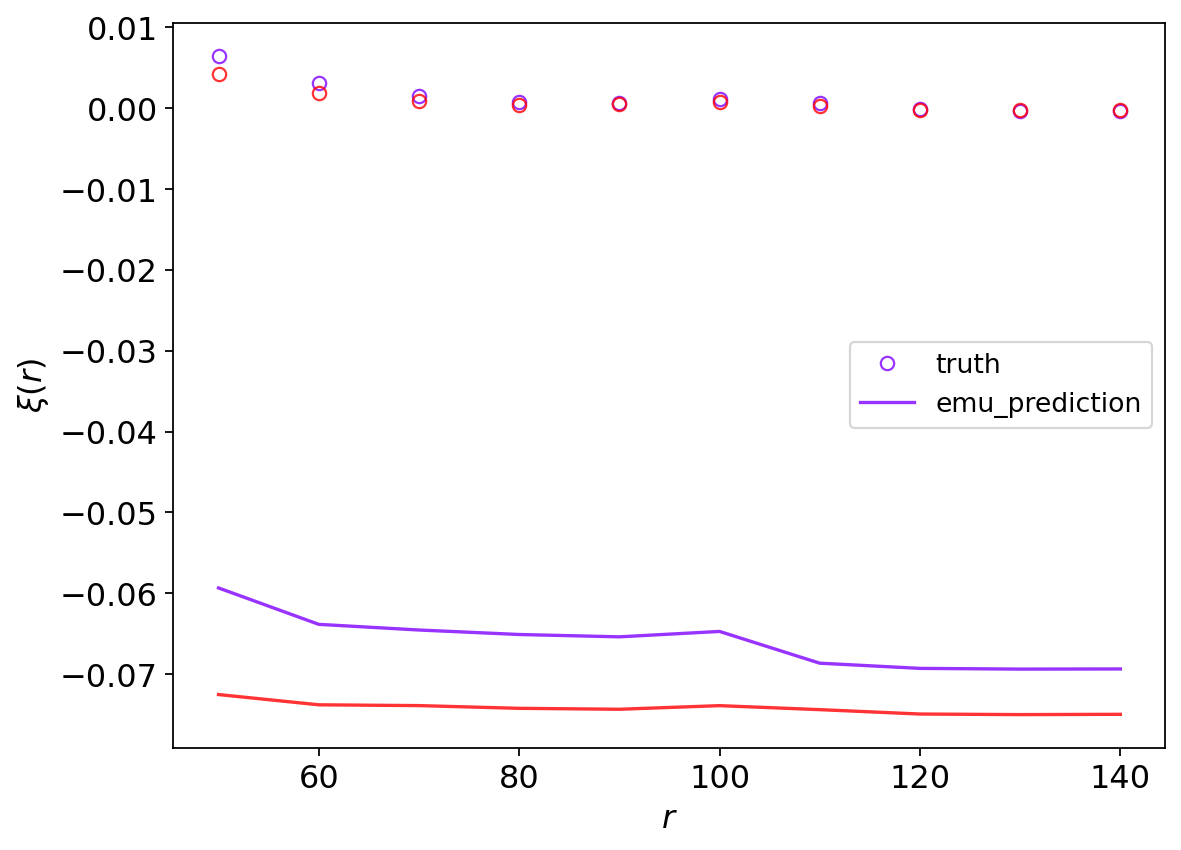

In [17]:
plt.figure(figsize=(8,6))
for i in range(n_plot):
    ys_test_plot = ys_test[idxs,:][i]
    ys_predict_plot = ys_predict[idxs][i]
    if i==0:
        label_test = 'truth'
        label_predict = 'emu_prediction'
    else:
        label_test = None
        label_predict = None
    plt.plot(r_vals[:n_values], ys_test_plot, alpha=0.8, label=label_test, marker='o', markerfacecolor='None', ls='None', color=colors[i])
    plt.plot(r_vals[:n_values], ys_predict_plot, alpha=0.8, label=label_predict, color=colors[i])
plt.xlabel('$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend()

Text(0, 0.5, 'fractional error')

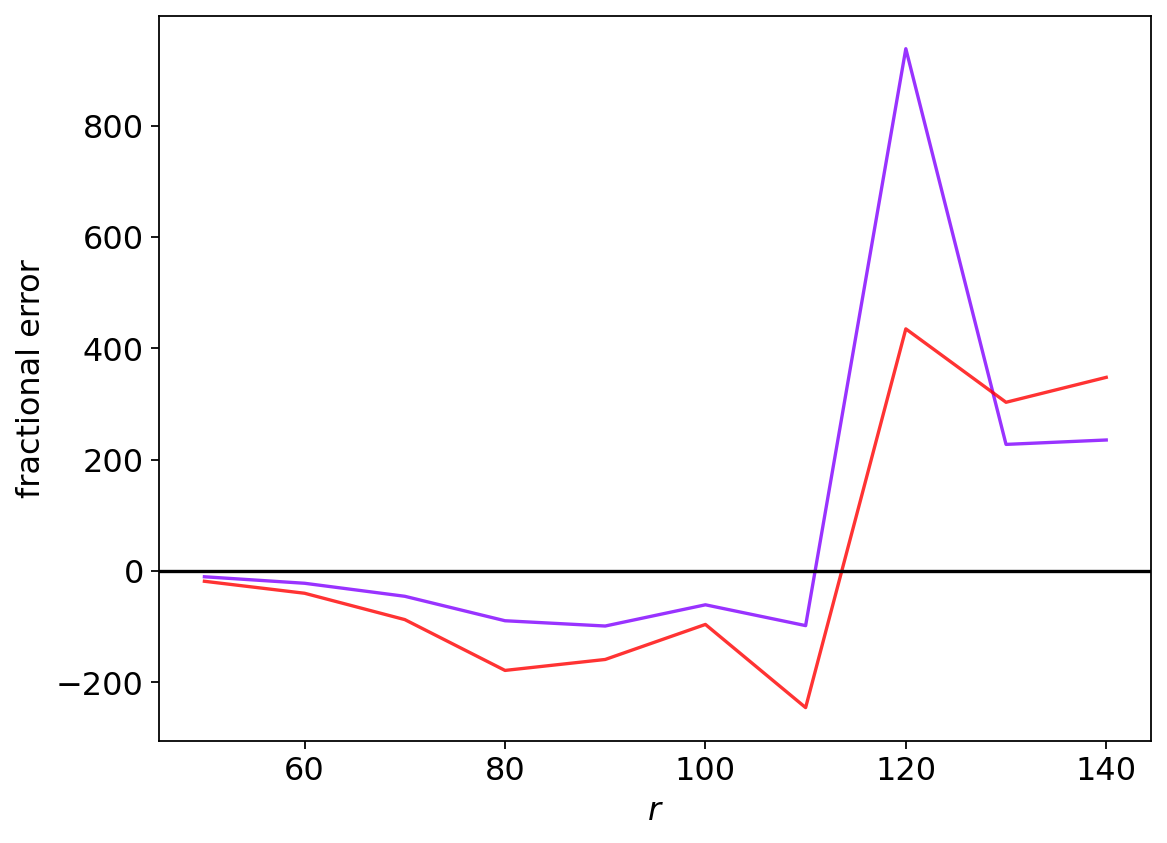

In [18]:
plt.figure(figsize=(8,6))
for i in range(n_plot):
    ys_test_plot = ys_test[idxs,:][i]
    ys_predict_plot = ys_predict[idxs][i]
    frac_err = (ys_predict_plot-ys_test_plot)/ys_test_plot
    plt.plot(r_vals, frac_err, alpha=0.8, color=colors[i])
plt.axhline(0.0, color='k')
plt.xlabel('$r$')
plt.ylabel(r'fractional error')